## Multicriterial optimization

The aim of this excercise is to present the operation of multicriterial optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def deflection(l, d):
    E = 207e9
    P = 1e3
    return 64*P*(l**3)/(3.0*E*np.pi*(d**4))
def stress(l, d):
    P = 1e3
    return 32*P*l/(np.pi*(d**3))
def mass(l, d):
    g = 7800
    return (g*l*(d**2)/4)

In [3]:
def constrained_function(x, c, w):
    l = x[0]
    d = x[1]
    return w*mass(l,d) + (1-w)*deflection(l,d)*(1e-3) + \
            c*(np.maximum(0, deflection(l,d) - 4e-3))**2 + \
            c*(np.maximum(0, stress(l,d) - 3e8))**2 +\
            c*(np.maximum(0, l-1))**2 + c*(np.maximum(0,d-5e-2))**2 + \
            c*(np.minimum(0, l-0.2))**2 + c*(np.minimum(0, d-1e-2))**2 + \
            c*(np.minimum(0, mass(l,d)))**2 + c*(np.minimum(0, deflection(l,d)))**2

In [4]:
def constrained_function2(l, d, c, w):
    return w*mass(l,d) + (1-w)*deflection(l,d) + \
            c*(1e3*np.maximum(0, deflection(l,d) - 5e-3))**2 + \
            c*(1e-8*np.maximum(0, stress(l,d) - 3e8))**2 +\
            c*(1e1*np.maximum(0, l-1))**2 + (c)*(1e2*np.maximum(0,d-5e-2))**2 + \
            c*(1e1*np.minimum(0, l-0.2))**2 + c*(1e2*np.minimum(0, d-1e-2))**2

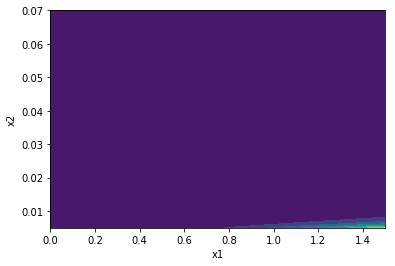

In [5]:
x1 = np.linspace(0, 1.5, 200)
x2 = np.linspace(0.5e-2, 7e-2, 200)
x1v, x2v = np.meshgrid(x1, x2)
z = constrained_function2(x1v, x2v, 0, 0.2)
plt.contourf(x1v,x2v,z)
plt.xlabel('x1')
plt.ylabel('x2')

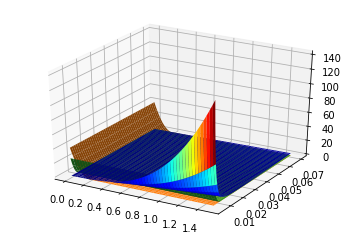

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 

plt.figure()
ax = plt.subplot(111, projection='3d')
ax.plot_surface(x1v,x2v,z, cmap=cm.jet)
ax.plot_surface(x1v, x2v, 1e3*np.minimum(0, x1v-0.2)**2)
ax.plot_surface(x1v, x2v, 1e6*np.minimum(0, x2v-1e-2)**2)

In [7]:
def create_new_base(direction, lam):
    new_base = np.zeros(direction.shape)
    D = direction.transpose()
    M = lam.transpose()
    Q = np.dot(D, M) #is really matrix multiplication for 2D arrays
    v = np.zeros(direction.shape)
    v[0] = Q[:,0] #as in classical method, first vector is unchanged, only normalized
    new_base[0] = v[0]/np.sqrt(np.dot(v[0].transpose(), v[0]))
    for j in range(1, len(direction)):
        scalar_dir = np.zeros(len(Q[0,:]))
        for k in range(0, j): #here happens the summation of vectors
            p = np.dot(Q[:,j].transpose(), new_base[k, :])
            p = np.multiply(p, new_base[k, :])
            scalar_dir = np.add(scalar_dir,p)
        v[j] = np.subtract(Q[:,j] ,scalar_dir)
        new_base[j] = v[j]/np.sqrt(np.dot(v[j].transpose(), v[j]))
    return new_base

def rosenbrock_method(function, x0, direction, s, alpha, beta, N, verbose, c, w):
    #alpha - expansion coefficient
    #beta - contraction coefficient
    lam = [0 for i in range(len(direction))] #success list for each direction
    p = [0 for i in range(len(direction))] #failure list for each direction
    i = 0
    x_base = x0
    x_list = []
    while i <= N:
        for j in range(len(direction)):
            if function(np.add(x_base,np.multiply(direction[j],s[j])),c, w) < function(x_base, c, w):
                #successful step
                x_base = np.add(x_base,np.multiply(direction[j],s[j]))
                x_list.append(x_base)
                lam[j] = np.add(lam[j],s[j])
                s[j] = np.multiply(alpha,s[j])
            elif function(np.add(x_base,np.multiply(direction[j],s[j])), c, w) >= function(x_base, c, w):
                #failed step
                s[j] = (-1)*s[j]*beta
                p[j] = np.add(p[j],1)
        for_all = 0
        for j in range(len(direction)):
            if p[j] !=0 and lam[j]!=0:
                for_all += 1
        if for_all == len(direction):
            l = np.zeros((2,2))
            l[0,0] = lam[0]
            l[1,0] = lam[1]
            l[1,1] = lam[1]
            direction = create_new_base(direction, l.transpose())  
            lam = [0 for i in range(len(direction))] #clear
            p = [0 for i in range(len(direction))] #clear
        i = i+1
    return x_base, x_list

In [55]:
def multicriterial_optimization(function, x_start, direction, s, alpha, beta, N, verbose, N2, error, w):
    min_list = []
    c = 0.5
    j = 0
    while j < N2:
        c = 2*c
        minimum, _ = rosenbrock_method(function, x_start, direction, s, alpha, beta, N, verbose, c, w)
        if function(minimum,c, w) < error:
            min_list.append(minimum)
            return min_list
        j += 1
        min_list.append(minimum)
    return min_list

In [59]:
w_list = []
for w in np.arange(0, 1.01, 0.01):
    #f1 is mass
    #f2 is deflection
    s = np.array([0.01,0.01])
    direction = np.array([[1.0,0.0], [0.0,1.0]])
    x_start = np.array([0.0, 0.0])
    N2 = 15
    N = 19
    alpha = 2
    beta = 0.5
    x_start[0] = (0.8)*np.random.random() + 0.2 #len
    x_start[1] = (4e-2)*np.random.random() + 1e-2 #diam
    minimum = multicriterial_optimization(constrained_function, x_start, direction, s, alpha, beta, N, 0, N2, 1e-3, w)
    #print("W : {}, length {}, diameter {}".format(w, minimum[-1][0], minimum[-1][1]))
    #print("W : {}, mass {}, deflection {}".format(w, mass(minimum[-1][0], minimum[-1][1]), \
    #                                         deflection(minimum[-1][0], minimum[-1][1])))
    w_list.append(minimum[-1])

In [60]:
lengths = [element[0] for element in w_list]
diameters = [element[1] for element in w_list]
function_of_mass = [mass(l, d) for l, d in zip(lengths, diameters)]
function_of_deflection = [deflection(l,d) for l,d in zip(lengths, diameters)]
k = [z for z in np.arange(0, 1.01, 0.01)]

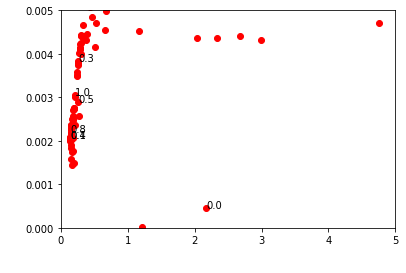

In [61]:
fig, ax = plt.subplots()
ax.scatter(function_of_mass, function_of_deflection, color='r')
ax.axis([0, 5, 0, 5e-3])
i = -1
for p, masses, deflections in zip(k, function_of_mass, function_of_deflection):
    i += 1
    if i%10 == 0:
        ax.annotate(p, (masses, deflections))

Clearly, the sought minimum is around (0.25, 0.001)

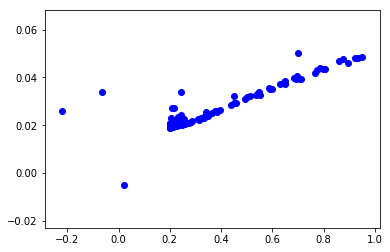

In [12]:
fig, ax = plt.subplots()
ax.scatter(lengths, diameters, color='b')

#### Conclusions:
    1. The multicriterial optimization is a way of accurately presenting the 
        trade-off between two objective functions.
    2. Despite the fact it is an effective way of calculating the relations 
        between set of objective functions, it does not provide reliable means 
        to investigate the pareto-front in any other way than visual. In case of more 
        than two objective functions, finding a dominating solutions is very difficult 
        to perform since little analytical methods are known.
    3. The convergence of the problem is heavily dependent on how to objective functions 
        are scaled in relation to each other (orders of magnitude might pose some problems)